(prior-work)=
# Prior Work

```{admonition}  Prior to our work, research on deep-learning-based EEG decoding was limited
* Few studies compared to published well-tuned feature-based decoding results
* Most EEG DL architectures had only 1-3 convolutional layers and included fully-connected layers
* Most work only considered very restricted frequency ranges
* Most studies only compared few design choices and training strategies
```

## Decoding Problems and Baselines

```{table} Decoding problems in deep-learning EEG decoding studies prior to our work. Studies with external baseline compared their decoding results to an external baseline result by other authors.
:name: prior-work-tasks-table

|  Decoding problem     | Number of studies  | With external baseline|
|:------|:-------------------|:---------------------------------|
|Imagined or Executed Movement|6|2|
|Oddball/P300|5|1|
|Epilepsy-related|4|2|
|Music Rhythm|2|0|
|Memory Performance/Cognitive Load|2|0|
|Driver Performance|1|0|
```

Prior to 2017, when the first work presented in this thesis was published, there was only limited literature on EEG decoding with deep learning. From 19 studies we identified at the time, most were about movement-related decoding problems such as decoding which body part (hand, feet etc.) a person is imagining to move (see {numref}`prior-work-tasks-table`). Only 5 of the 19 studies compared their decoding results to an external baseline result, limiting the evaluation of the decoding results. To advance the understanding of EEG deep learning decoding, we therefore decided to first focus on widely researched movement-related decoding tasks with strong feature-based baselines.

## Input Domains and Frequency Ranges

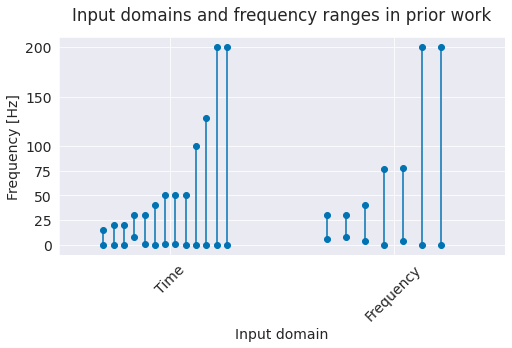

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn
import numpy as np
import re
from myst_nb import glue
seaborn.set_palette('colorblind')
seaborn.set_style('darkgrid')
import re

%matplotlib inline
%config InlineBackend.figure_format = 'png'
#matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 14
a = np.array(['Time,  8–30 Hz ', 'Time, 0.1–40 Hz ', 'Time, 0.05–15 Hz ',
       'Time, 0.3–20 Hz ', 'Frequency, 6–30 Hz ', ' Frequency, 0–200 Hz ',
       'Time,  1–50 Hz ', ' Time,  0–100 HZ ',
       'Frequency, mean amplitude for 0–7 Hz, 7–14 Hz, 14–49 Hz ',
       'Time, 0.5–50 Hz ', 'Time,  0–128 Hz ',
       ' Frequency, mean power for 4–7 Hz, 8–13 Hz, 13–30 Hz ',
       'Time, 0.5–30Hz ', 'Time, 0.1–50 Hz ',
       'Frequency, 4–40 Hz, using FBCSP ',
       ' Time and frequency evaluated, 0-200 Hz ', 'Frequency, 8–30 Hz ',
       'Time, 0.15–200 Hz ', ' Time, 0.1-20 Hz '])
domain_strings = [s.split(',')[0] for s in a]
start_fs = [float(re.sub(r'[a-z ]+',r'', re.split(r'[–-–-]'," ".join(s.split(',')[1:]))[0])) for s in a]
end_fs = [float(re.sub(r'[a-z HZFBCSP]+',r'', re.split(r'[–-–-]'," ".join(s.split(',')[1:]))[1])) for s in a]
domain_strings = np.array(domain_strings)
start_fs = np.array(start_fs)
end_fs = np.array(end_fs)

freq_mask = np.array(['freq' in s.lower() for s in domain_strings])
time_mask = np.array(['time' in s.lower() for s in domain_strings])

fig = plt.figure(figsize=(8,4))
rng = np.random.RandomState(98349384)
color = seaborn.color_palette()[0]
i_sort = np.flatnonzero(time_mask)[np.argsort(end_fs[time_mask])]
for i, (d,s,e) in enumerate(zip(
        domain_strings[i_sort], start_fs[i_sort], end_fs[i_sort])):
    offset = 0.6*i/len(i_sort) - 0.3
    plt.plot([offset,offset] , [s, e], marker='o', alpha=1, color=color, ls='-')
i_sort = np.flatnonzero(freq_mask)[np.argsort(end_fs[freq_mask])]
for i, (d,s,e) in enumerate(zip(
        domain_strings[i_sort], start_fs[i_sort], end_fs[i_sort])):
    offset = 0.6*i/len(i_sort) + 0.7
    plt.plot([offset,offset] , [s, e], marker='o', alpha=1, color=color, ls='-')

plt.xlim(-0.5,1.5)
plt.xlabel("Input domain")
plt.ylabel("Frequency [Hz]")
plt.xticks([0,1], ["Time", "Frequency"], rotation=45)
plt.title("Input domains and frequency ranges in prior work", y=1.05)
plt.yticks([0,25,50,75,100,150,200])
glue('input_domain_fig', fig)
plt.close(fig)
None

```{glue:figure} input_domain_fig


*Input domains and frequency ranges in prior work*. Grey lines represent frequency ranges of individual studies. Note that many studies only include frequencies below 50 Hz, some use very restricted ranges (alpha/beta band).
```

Deep networks can either decode directly from the time-domain EEG or process the data in the frequency domain, for example after a Fourier transformation. 12 of the prior studies used time-domain inputs, 6 used frequency-domain inputs and one used both. We decided to work directly in the time domain, as the deep networks should be capable to learn to extract any needed spectral information from the time-domain input. 

Most prior studies that were working in the time domain only used frequencies below 50 Hz. We were interested in how well deep networks can also extract lesser-used higher-frequency components of the EEG signal. We used a sampling rate of 250 Hz, which means we were able to analyze frequencies up to the Nyquist frequency of 125 Hz. As a suitable dataset where high-frequency information may help decoding, we included our high-gamma dataset in our study, since it was recorded specifically to allow extraction of higher-frequency (>50 Hz) information from scalp EEG.

## Network Architectures

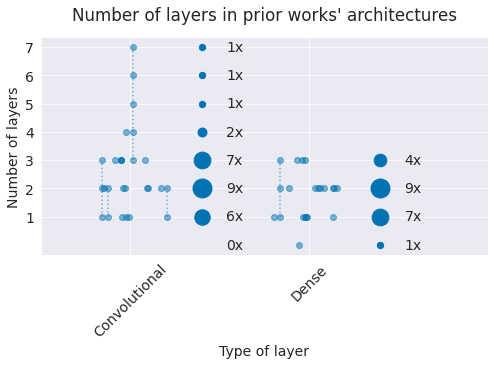

In [2]:


ls = np.array([' 2/2 ', ' 3/1 ', ' 2/2 ', ' 3/2 ', ' 1/1 ', ' 1/2 ', ' 1/3 ',
       ' 1–2/2 ', ' 3/1 (+ LSTM as postprocessor) ', ' 4/3 ', ' 1-3/1-3 ',
       ' 3–7/2 (+ LSTM or other temporal post-processing (see design choices)) ',
       ' 2/1 ', ' 3/3 (Spatio-temporal regularization) ',
       ' 2/2 (Final fully connected layer uses concatenated output by convolutionaland fully connected layers) ',
       ' 1-2/1 ',
       '2/0 (Convolutional deep belief network, separately trained RBF-SVM classifier) ',
       ' 3/1 (Convolutional layers trained as convolutional stacked autoencoder with target prior) ',
       ' 2/2 '])

conv_ls = [l.split('/')[0] for l in ls]
low_conv_ls = [int(re.split(r'[–-]', c)[0])for c in conv_ls]
high_conv_ls = [int(re.split(r'[–-]', c)[-1])for c in conv_ls]
dense_ls = [l.split('/')[1] for l in ls]
low_dense_ls = [int(re.split(r'[–-]', c[:8])[0][:2])for c in dense_ls]
high_dense_ls = [int(re.split(r'[–-]', c[:8])[-1][:2])for c in dense_ls]

all_conv_ls = np.concatenate([np.arange(low_c, high_c+1) for low_c, high_c in zip(low_conv_ls, high_conv_ls)])
all_dense_ls = np.concatenate([np.arange(low_c, high_c+1) for low_c, high_c in zip(low_dense_ls, high_dense_ls)])
bincount_conv = np.bincount(all_conv_ls)
bincount_dense = np.bincount(all_dense_ls)
rng = np.random.RandomState(98349384)
color = seaborn.color_palette()[0]
fig = plt.figure(figsize=(8,4))
for low_c, high_c in zip(low_conv_ls, high_conv_ls):
    offset = rng.randn(1) * 0.1
    tried_cs = np.arange(low_c, high_c+1)
    plt.plot([offset,] * len(tried_cs), tried_cs, marker='o', alpha=0.5, color=color, ls=':')
    
for i_c, n_c in enumerate(bincount_conv):
    plt.scatter(0.4, i_c, color=color, s=n_c*40)
    plt.text(0.535, i_c, str(n_c)+ "x", ha='left', va='center')

for low_c, high_c in zip(low_dense_ls, high_dense_ls):
    offset = 1 + rng.randn(1) * 0.1
    tried_cs = np.arange(low_c, high_c+1)
    plt.plot([offset,] * len(tried_cs), tried_cs, marker='o', alpha=0.5, color=color, ls=':')
    
for i_c, n_c in enumerate(bincount_dense):
    plt.scatter(1.4, i_c, color=color, s=n_c*40)
    plt.text(1.535, i_c, str(n_c)+ "x", ha='left', va='center')

plt.xlim(-0.5,2)
plt.xlabel("Type of layer")
plt.ylabel("Number of layers")
plt.xticks([0,1], ["Convolutional", "Dense"], rotation=45)
plt.yticks([1,2,3,4,5,6,7]);
plt.title("Number of layers in prior works' architectures", y=1.05)
glue('layernum_fig', fig)
plt.close(fig)
None

```{glue:figure} layernum_fig


*Number of layers in prior work*. Small grey markers represent individual architectures. Dashed lines indicate different number of layers investigated in a single study (e.g., a single study investigated 3-7 convolutional layers). Larger grey markers indicate sum of occurences of that layer number over all studies (e.g., 9 architectures used 2 convolutional layers). Note most architectures use only 1-3 convolutional layers.
```


The architectures used in prior work typically only included up to 3 layers, with only 2 studies considering more layers. As network architectures in other domains tend to be a lot deeper, we also evalauted architectures with a larger number of layers in our work. Several architectures from prior work also included fully-connected layers with larger number of parameters which had fallen out of favor in computer-vision deep-learning architectures due to their large compute and memory requirements with little accuracy benefit. Our architectures do not include traditional fully-connected layers with large number of parameters.

## Hyperparameter Evaluations

```{table} Design choices and training strategies that prior deep-learning EEG decoding studies had studies.
:name: prior-work-design-choices-table

| Study | Design choices| Training strategies |
|:------|:------------|:---------------|
|{cite}`lawhern_eegnet:_2016` | Kernel sizes  |   |
|{cite}`sun_remembered_2016` | | Different time windows |
|{cite}`tabar_novel_2017` | Addition of six-layer stacked autoencoder on ConvNet features <br> Kernel sizes | |
| {cite}`liang_predicting_2016` | |Different subdivisions of frequency range <br>Different lengths of time crops <br>Transfer learning with auxiliary non-epilepsy datasets |
|{cite}`hajinoroozi_eeg-based_2016` | Replacement of convolutional layers by restricted Boltzmann machines with slightly varied network architecture}| |
|{cite}`antoniades_deep_2016` | 1 or 2 convolutional layers ||
|{cite}`page_wearable_2016` | | Cross-subject supervised training, within-subject finetuning of fully connected layers |
|{cite}`bashivan_learning_2016` | Number of convolutional layers <br>Temporal processing of ConvNet output by max pooling, temporal convolution, LSTM or temporal convolution + LSTM | |
|{cite}`stober_learning_2016` | Kernel sizes | Pretraining first layer as convolutional autoencoder with different constraints |
|{cite}`sakhavi_parallel_2015` | Combination ConvNet and MLP (trained on different features) vs. only ConvNet vs. only MLP | |
|{cite}`stober_using_2014`  | Best values from automatic hyperparameter optimization: frequency cutoff, one vs two layers, kernel sizes, number of channels, pooling width | Best values from automatic hyperparameter optimization: learning rate, learning rate decay, momentum, final momentum |
|{cite}`wang_deep_2013` | Partially supervised CSA | |
|{cite}`cecotti_convolutional_2011` | Electrode subset (fixed or automatically determined) <br>Using only one spatial filter <br>Different ensembling strategies||
```

Prior work varied widely in which design choices and training strategies were compared. 6 of the studies did not compare any design choices or  training strategy hyperparamters. The other 13 studies evaluated different hyperparameters, with the most common one the kernel size (see {numref}`prior-work-design-choices-table`). Only one study evaluated a wider range of hyperparameters {cite}`stober_using_2014`. To fill this gap, we compared a wider range of design choices and training strategies and specifically evaluated in how far improvements of computer vision architecture design choices and training strategies also lead to improvements in EEG decoding.

## Visualizations

```{table} Visualizations presented in prior work.
:name: prior-work-visualizations-table
| Study | Visualization type(s) | Visualization findings   |
|:-------|:-----|:-----|
|{cite}`sun_remembered_2016`| Weights (spatial)| Largest weights found over prefrontal and temporal cortex|
|{cite}`manor_multimodal_2016` | Weights <br> Activations <br> Saliency maps by gradient | Weights showed typical P300 distribution <br>Activations were high at plausible times (300-500ms) <br>Saliency maps showed plausible spatio-temporal plots| 
|{cite}`tabar_novel_2017` | Weights (spatial + frequential) | Some weights represented difference of values of two electrodes on different sides of head|
|{cite}`liang_predicting_2016` | Weights <br> Clustering of weights | Clusters of weights showed typical frequency band subdivision (delta, theta, alpha, beta, gamma)|
|{cite}`antoniades_deep_2016` | Weights <br>Correlation weights and interictal epileptic discharges (IED) <br>Activations                        | Weights increasingly correlated with IED waveforms with increasing number of training iterations <br>Second layer captured more complex and well-defined epileptic shapes than first layer <br>IEDs led to highly synchronized activations for neighbouring electrodes |
|{cite}`thodoroff_learning_2016` | Input occlusion and effect on prediction accuracy | Allowed to locate areas critical for seizure |
|{cite}`george_single-trial_2016` | Weights (spatial) | Some filter weights had expected topographic distributions for P300 <br>Others filters had large weights on areas not traditionally associated with P300|
|{cite}`bashivan_learning_2016` | Inputs that maximally activate given filter <br>Activations of these inputs <br>"Deconvolution" for these inputs | Different filters were sensitive to different frequency bands <br>Later layers had more spatially localized activations <br>Learned features had noticeable links to well-known electrophysiological markers of cognitive load <br> |
|{cite}`stober_learning_2016` | Weights (spatial+3 timesteps, pretrained as autoencoder) | Different constraints led to different weights, one type of constraints could enforce weights that are similar across subjects; other type of constraints led to weights that have similar spatial topographies under different architectural configurations and preprocessings |
|{cite}`manor_convolutional_2015` | Weights <br> Mean and single-trial activations | Spatiotemporal regularization led to softer peaks in weights <br>Spatial weights showed typical P300 distribution <br>Activations mostly had peaks at typical times (300-400ms) |
|{cite}`cecotti_convolutional_2011` | Weights | Spatial filters were similar for different architectures <br>Spatial filters were different (more focal, more diffuse) for different subjects |
```

Visualizations can help understand what information the networks are extracting from the EEG signal. 11 of the prior 19 studies presented any visualizations. These studies mostly focussed on analyzing weights and activations, see {numref}`prior-work-visualizations-table`. In our work, we focused on investigating how far the networks extract features known to work well for movement-related decoding, see {ref}`perturbation-visualization`.

```{admonition} We aimed to thoroughly evaluate deep-learning-based EEG decoding by...
:class: tip
* using well-researched EEG movement-related decoding tasks with strong baselines
* using a dataset suitable to analyze extraction of higher-frequency information
* trying shallower EEG-specific as well as deeper more generic architectures
* evaluating many design choices and two training strategies
* investigating in how far networks learn to extract well-known EEG features
```